In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from datetime import datetime, timedelta

In [116]:
wego = pd.read_csv('../data/headway_data_with_datetimes.csv')
wego.head(1)

C:\Users\18285\anaconda3\envs\geospatial\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS
0,120230801,1,99464095,8/1/2023,GALLATIN PIKE,5600,2374,347902,0,TO DOWNTOWN,...,0,1,0,0.0,0,2,46.866666,2023-08-01 - 347902,56,ON TIME


#### Counting and removing na values

In [117]:
wego['ACTUAL_ARRIVAL_TIME'].isna().sum()

11459

In [118]:
wego['ADHERENCE'].isna().sum()

11468

In [119]:
wego_drop = wego.dropna(subset=['ADHERENCE'])

In [120]:
wego_drop = wego.dropna(subset=['ACTUAL_ARRIVAL_TIME'])

In [121]:
wego_drop['ADHERENCE'].isna().sum()

12

#### Convert time fields to DATETIME

In [122]:
wego_drop[['ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','SCHEDULED_TIME']]

,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,SCHEDULED_TIME
0,8/1/2023 3:44,8/1/2023 4:31,8/1/2023 4:30
1,8/1/2023 3:59,8/1/2023 4:34,8/1/2023 4:33
2,8/1/2023 4:13,8/1/2023 4:55,8/1/2023 4:55
3,8/1/2023 4:14,8/1/2023 4:23,8/1/2023 4:23
4,8/1/2023 4:20,8/1/2023 4:20,8/1/2023 4:20
...,...,...,...
338864,10/1/2023 1:09,10/1/2023 1:09,10/1/2023 0:53
338865,10/1/2023 1:11,10/1/2023 1:11,10/1/2023 0:19
338866,10/1/2023 1:15,10/1/2023 1:18,10/1/2023 1:02
338867,10/1/2023 1:18,10/1/2023 1:18,10/1/2023 0:27


In [123]:
wego_drop['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego_drop['ACTUAL_ARRIVAL_TIME'], format='%m/%d/%Y %H:%M')
wego_drop['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego_drop['ACTUAL_DEPARTURE_TIME'], format='%m/%d/%Y %H:%M')

<ipython-input-123-e9d972046091>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego_drop['ACTUAL_ARRIVAL_TIME'], format='%m/%d/%Y %H:%M')
<ipython-input-123-e9d972046091>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego_drop['ACTUAL_DEPARTURE_TIME'], format='%m/%d/%Y %H:%M')


In [124]:
wego_drop.dtypes

CALENDAR_ID                           int64
SERVICE_ABBR                          int64
ADHERENCE_ID                          int64
DATE                                 object
ROUTE_ABBR                           object
BLOCK_ABBR                            int64
OPERATOR                              int64
TRIP_ID                               int64
OVERLOAD_ID                           int64
ROUTE_DIRECTION_NAME                 object
TIME_POINT_ABBR                      object
ROUTE_STOP_SEQUENCE                 float64
TRIP_EDGE                             int64
LATITUDE                            float64
LONGITUDE                           float64
SCHEDULED_TIME                       object
ACTUAL_ARRIVAL_TIME          datetime64[ns]
ACTUAL_DEPARTURE_TIME        datetime64[ns]
ADHERENCE                           float64
SCHEDULED_HDWY                      float64
ACTUAL_HDWY                         float64
HDWY_DEV                            float64
ADJUSTED_EARLY_COUNT            

In [125]:
wego_drop['LAYOVER'] = wego_drop['ACTUAL_DEPARTURE_TIME'] - wego_drop['ACTUAL_ARRIVAL_TIME']

<ipython-input-125-c9df8814e5a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['LAYOVER'] = wego_drop['ACTUAL_DEPARTURE_TIME'] - wego_drop['ACTUAL_ARRIVAL_TIME']


In [126]:
wego_drop['LAYOVER'] = wego_drop['LAYOVER'].dt.total_seconds()

<ipython-input-126-9836be053efe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['LAYOVER'] = wego_drop['LAYOVER'].dt.total_seconds()


In [129]:
wego_drop = wego_drop.dropna(subset=['LAYOVER'])

In [130]:
wego_drop['LAYOVER'] = wego_drop['LAYOVER'].astype(int)

In [140]:
wego_drop.dtypes

CALENDAR_ID                           int64
SERVICE_ABBR                          int64
ADHERENCE_ID                          int64
DATE                                 object
ROUTE_ABBR                           object
BLOCK_ABBR                            int64
OPERATOR                              int64
TRIP_ID                               int64
OVERLOAD_ID                           int64
ROUTE_DIRECTION_NAME                 object
TIME_POINT_ABBR                      object
ROUTE_STOP_SEQUENCE                 float64
TRIP_EDGE                             int64
LATITUDE                            float64
LONGITUDE                           float64
SCHEDULED_TIME                       object
ACTUAL_ARRIVAL_TIME          datetime64[ns]
ACTUAL_DEPARTURE_TIME        datetime64[ns]
ADHERENCE                           float64
SCHEDULED_HDWY                      float64
ACTUAL_HDWY                         float64
HDWY_DEV                            float64
ADJUSTED_EARLY_COUNT            

In [141]:
wego_drop[['ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER']]

,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER
0,2023-08-01 03:44:00,2023-08-01 04:31:00,2820
1,2023-08-01 03:59:00,2023-08-01 04:34:00,2100
2,2023-08-01 04:13:00,2023-08-01 04:55:00,2520
3,2023-08-01 04:14:00,2023-08-01 04:23:00,540
4,2023-08-01 04:20:00,2023-08-01 04:20:00,0
...,...,...,...
338864,2023-10-01 01:09:00,2023-10-01 01:09:00,0
338865,2023-10-01 01:11:00,2023-10-01 01:11:00,0
338866,2023-10-01 01:15:00,2023-10-01 01:18:00,180
338867,2023-10-01 01:18:00,2023-10-01 01:18:00,0


In [142]:
trip_1 = wego_drop[['DATE','OPERATOR','TRIP_ID','CORRECTED_TRIP_ID','TRIP_EDGE','ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER','ADHERENCE','DWELL_IN_MINS']]
trip_1 = trip_edge[trip_edge['TRIP_EDGE']== 1]
trip_1.head()

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER,ADHERENCE,DWELL_IN_MINS
0,8/1/2023,2374,347902,2023-08-01 - 347902,1,2023-08-01 03:44:00,2023-08-01 04:31:00,2820,-1.283333,46.866666
1,8/1/2023,2112,347114,2023-08-01 - 347114,1,2023-08-01 03:59:00,2023-08-01 04:34:00,2100,-1.766666,35.433333
2,8/1/2023,522,347164,2023-08-01 - 347164,1,2023-08-01 04:13:00,2023-08-01 04:55:00,2520,-0.316666,42.116666
3,8/1/2023,1206,347480,2023-08-01 - 347480,1,2023-08-01 04:14:00,2023-08-01 04:23:00,540,-0.900000,9.483333
4,8/1/2023,1147,345498,2023-08-01 - 345498,1,2023-08-01 04:20:00,2023-08-01 04:20:00,0,-0.716666,0.000000


In [143]:
trip_2 = wego_drop[['DATE','OPERATOR','TRIP_ID','CORRECTED_TRIP_ID','TRIP_EDGE','ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER','ADHERENCE','DWELL_IN_MINS']]
trip_2 = trip_edge[trip_edge['TRIP_EDGE']== 2]
trip_2.head()

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER,ADHERENCE,DWELL_IN_MINS
11,8/1/2023,1147,345498,2023-08-01 - 345498,2,2023-08-01 04:36:00,2023-08-01 04:36:00,0,1.833333,0.0
41,8/1/2023,2374,347902,2023-08-01 - 347902,2,2023-08-01 05:01:00,2023-08-01 05:01:00,0,3.700000,0.0
48,8/1/2023,1040,345104,2023-08-01 - 345104,2,2023-08-01 05:03:00,2023-08-01 05:03:00,0,6.283333,0.0
52,8/1/2023,1147,345499,2023-08-01 - 345499,2,2023-08-01 05:04:00,2023-08-01 05:04:00,0,5.650000,0.0
54,8/1/2023,1682,346804,2023-08-01 - 346804,2,2023-08-01 05:05:00,2023-08-01 05:05:00,0,4.783333,0.0


In [144]:
first_last_adherence = pd.merge(trip_1, trip_2, on=['CORRECTED_TRIP_ID'], how='inner')
first_last_adherence.head()

,DATE_x,OPERATOR_x,TRIP_ID_x,CORRECTED_TRIP_ID,TRIP_EDGE_x,ACTUAL_ARRIVAL_TIME_x,ACTUAL_DEPARTURE_TIME_x,LAYOVER_x,ADHERENCE_x,DWELL_IN_MINS_x,DATE_y,OPERATOR_y,TRIP_ID_y,TRIP_EDGE_y,ACTUAL_ARRIVAL_TIME_y,ACTUAL_DEPARTURE_TIME_y,LAYOVER_y,ADHERENCE_y,DWELL_IN_MINS_y
0,8/1/2023,2374,347902,2023-08-01 - 347902,1,2023-08-01 03:44:00,2023-08-01 04:31:00,2820,-1.283333,46.866666,8/1/2023,2374,347902,2,2023-08-01 05:01:00,2023-08-01 05:01:00,0,3.700000,0.0
1,8/1/2023,2112,347114,2023-08-01 - 347114,1,2023-08-01 03:59:00,2023-08-01 04:34:00,2100,-1.766666,35.433333,8/1/2023,2112,347114,2,2023-08-01 05:10:00,2023-08-01 05:10:00,0,-0.200000,0.0
2,8/1/2023,522,347164,2023-08-01 - 347164,1,2023-08-01 04:13:00,2023-08-01 04:55:00,2520,-0.316666,42.116666,8/1/2023,522,347164,2,2023-08-01 05:31:00,2023-08-01 05:31:00,0,0.116666,0.0
3,8/1/2023,1206,347480,2023-08-01 - 347480,1,2023-08-01 04:14:00,2023-08-01 04:23:00,540,-0.900000,9.483333,8/1/2023,1206,347480,2,2023-08-01 05:08:00,2023-08-01 05:08:00,0,-1.216666,0.0
4,8/1/2023,1147,345498,2023-08-01 - 345498,1,2023-08-01 04:20:00,2023-08-01 04:20:00,0,-0.716666,0.000000,8/1/2023,1147,345498,2,2023-08-01 04:36:00,2023-08-01 04:36:00,0,1.833333,0.0


In [145]:
first_last_adherence.drop(columns=['DATE_y','OPERATOR_y','TRIP_ID_y','TRIP_EDGE_y', 'ACTUAL_ARRIVAL_TIME_y','ACTUAL_ARRIVAL_TIME_x', 'TRIP_EDGE_x', 'ACTUAL_ARRIVAL_TIME_y','ACTUAL_DEPARTURE_TIME_x','ACTUAL_ARRIVAL_TIME_y','LAYOVER_y', 'DWELL_IN_MINS_y','ACTUAL_DEPARTURE_TIME_y'], axis = 1, inplace=True)
first_last_adherence.head()

,DATE_x,OPERATOR_x,TRIP_ID_x,CORRECTED_TRIP_ID,LAYOVER_x,ADHERENCE_x,DWELL_IN_MINS_x,ADHERENCE_y
0,8/1/2023,2374,347902,2023-08-01 - 347902,2820,-1.283333,46.866666,3.700000
1,8/1/2023,2112,347114,2023-08-01 - 347114,2100,-1.766666,35.433333,-0.200000
2,8/1/2023,522,347164,2023-08-01 - 347164,2520,-0.316666,42.116666,0.116666
3,8/1/2023,1206,347480,2023-08-01 - 347480,540,-0.900000,9.483333,-1.216666
4,8/1/2023,1147,345498,2023-08-01 - 345498,0,-0.716666,0.000000,1.833333


In [146]:
first_last_adherence = first_last_adherence.rename(columns={'DATE_x': 'DATE', 'OPERATOR_x': 'OPERATOR','TRIP_ID_x':'TRIP_ID','LAYOVER_x':'FIRST_LAYOVER','ADHERENCE_x':'FIRST_ADHERENCE','DWELL_IN_MINS_x':'FIRST_DWELL','ADHERENCE_y':'LAST_ADHERENCE'})
first_last_adherence.head(5)

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,FIRST_LAYOVER,FIRST_ADHERENCE,FIRST_DWELL,LAST_ADHERENCE
0,8/1/2023,2374,347902,2023-08-01 - 347902,2820,-1.283333,46.866666,3.700000
1,8/1/2023,2112,347114,2023-08-01 - 347114,2100,-1.766666,35.433333,-0.200000
2,8/1/2023,522,347164,2023-08-01 - 347164,2520,-0.316666,42.116666,0.116666
3,8/1/2023,1206,347480,2023-08-01 - 347480,540,-0.900000,9.483333,-1.216666
4,8/1/2023,1147,345498,2023-08-01 - 345498,0,-0.716666,0.000000,1.833333


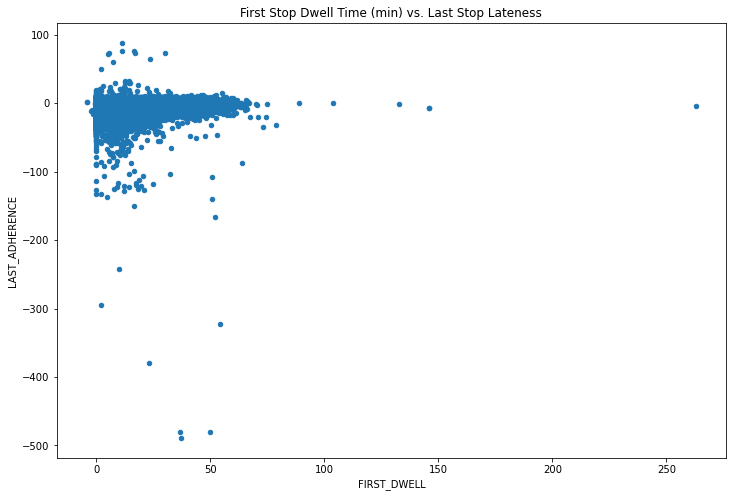

In [147]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_DWELL', y = 'LAST_ADHERENCE', figsize = (12,8))
plt.title('First Stop Dwell Time (min) vs. Last Stop Lateness');

In [151]:
first_last_adherence[['FIRST_DWELL', 'LAST_ADHERENCE']].corr()

,FIRST_DWELL,LAST_ADHERENCE
FIRST_DWELL,1.00000,0.10153
LAST_ADHERENCE,0.10153,1.00000


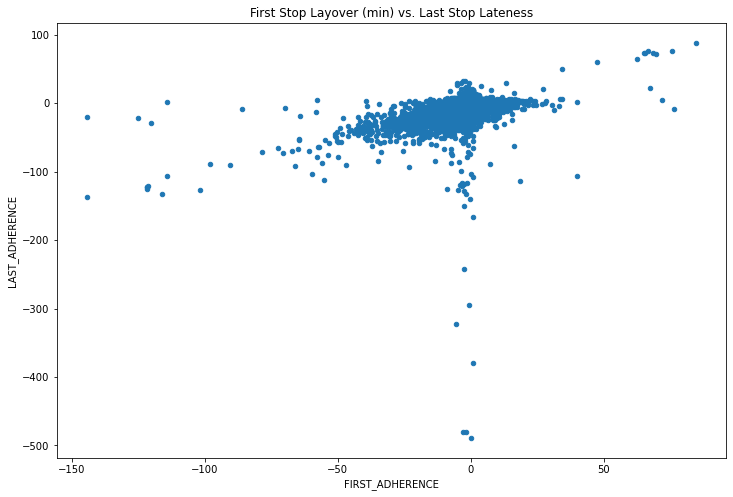

In [149]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_ADHERENCE', y = 'LAST_ADHERENCE', figsize = (12,8))
plt.title('First Stop Layover (min) vs. Last Stop Lateness');

In [150]:
first_last_adherence[['FIRST_ADHERENCE', 'LAST_ADHERENCE']].corr()

,FIRST_ADHERENCE,LAST_ADHERENCE
FIRST_ADHERENCE,1.000000,0.437105
LAST_ADHERENCE,0.437105,1.000000


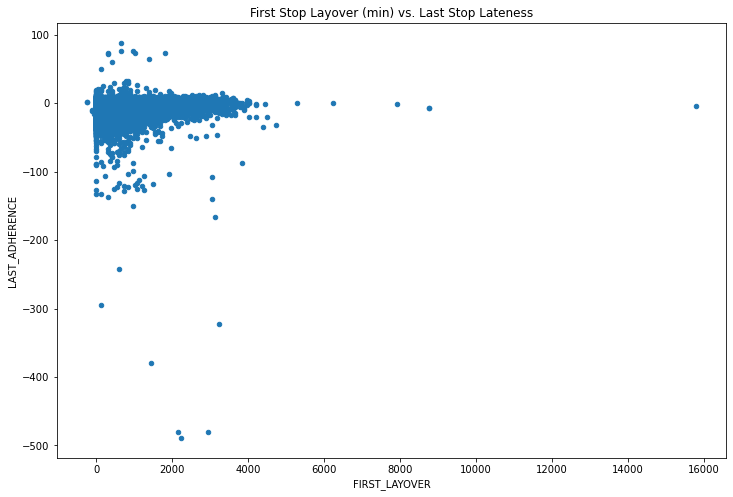

In [152]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_LAYOVER', y = 'LAST_ADHERENCE', figsize = (12,8))
plt.title('First Stop Layover (seconds) vs. Last Stop Lateness');